In [82]:
import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt

In [83]:
# 이미지를 numpy로 가져오는 함수
def getImageData(path):
    filepath = path
    data = glob.glob(filepath + '*')
    feature = []
    target = []
    for path_ in data:
        extension = path_.split('/')[-1].split('.')[1]
        num = path_.split('/')[-1].split('.')[0].split('_')[1]
        label = path_.split('/')[-1].split('.')[0].split('_')[0]

        if label == 'image' and extension == 'png':
            img = Image.open(path_)
            img = np.array(img)
            feature.append(img)

            ans = Image.open(filepath+f'mask_{num}.png')
            ans = np.array(ans)
            target.append(ans)

    return np.array(feature), np.array(target)

In [84]:
train_x, train_y = getImageData('image/train/')

In [85]:
test_x, test_y = getImageData('image/test/')

In [86]:
train_x = train_x.astype('float32')/255
train_y = train_y.astype('float32')/255
test_x = test_x.astype('float32')/255
test_y = test_y.astype('float32')/255

In [87]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((3200, 96, 96), (3200, 96, 96), (800, 96, 96), (800, 96, 96))

In [88]:
train_y

array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1.

In [89]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D,UpSampling2D,Flatten,Reshape

train_x =  train_x.reshape(train_x.shape[0],96,96,1)
train_y =  train_y.reshape(train_y.shape[0],96,96,1)
test_x = test_x.reshape(test_x.shape[0],96,96,1)
test_y = test_y.reshape(test_y.shape[0],96,96,1)

autoencoder = Sequential()

In [90]:
autoencoder.add(Conv2D(16, kernel_size=3, padding='same',input_shape=(96,96,1),activation='relu'))
autoencoder.add(MaxPooling2D(pool_size=2,padding='same'))
autoencoder.add(Conv2D(8,kernel_size=3,activation='relu',padding='same'))
autoencoder.add(MaxPooling2D(pool_size=2,padding='same'))
autoencoder.add(Conv2D(8,kernel_size=3,activation='relu',padding='same'))

In [91]:
autoencoder.add(Conv2D(8,kernel_size=3, padding='same',activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(8,kernel_size=3,padding='same',activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(16,kernel_size=3,padding='same',activation='relu'))
# autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(1,kernel_size=3,padding='same',activation='sigmoid'))


In [92]:
autoencoder.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 96, 96, 16)        160       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 48, 48, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 48, 48, 8)         1160      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 24, 24, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 24, 24, 8)         584       
                                                                 
 conv2d_45 (Conv2D)          (None, 24, 24, 8)        

In [99]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
mc = ModelCheckpoint('./ag.hdf5',verbose=1,save_best_only=True)
es = EarlyStopping(monitor='val_loss',patience=300)
autoencoder.compile(optimizer='adam',loss='binary_crossentropy')
history = autoencoder.fit(train_x,train_y,epochs=500,batch_size=64,validation_split=0.25,callbacks=[mc, es])

Epoch 1/500
38/38 [==============================] - ETA: 0s - loss: 0.2291
Epoch 1: val_loss improved from inf to 0.22528, saving model to ./ag.hdf5
38/38 [==============================] - 7s 175ms/step - loss: 0.2291 - val_loss: 0.2253
Epoch 2/500
38/38 [==============================] - ETA: 0s - loss: 0.2208
Epoch 2: val_loss improved from 0.22528 to 0.22453, saving model to ./ag.hdf5
38/38 [==============================] - 6s 171ms/step - loss: 0.2208 - val_loss: 0.2245
Epoch 3/500
38/38 [==============================] - ETA: 0s - loss: 0.2216
Epoch 3: val_loss improved from 0.22453 to 0.21833, saving model to ./ag.hdf5
38/38 [==============================] - 7s 171ms/step - loss: 0.2216 - val_loss: 0.2183
Epoch 4/500
38/38 [==============================] - ETA: 0s - loss: 0.2379
Epoch 4: val_loss did not improve from 0.21833
38/38 [==============================] - 7s 172ms/step - loss: 0.2379 - val_loss: 0.2333
Epoch 5/500
38/38 [==============================] - ETA: 0s - 

25/25 [==============================] - 0s 19ms/step


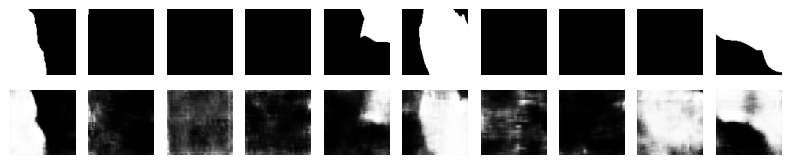

In [102]:

random_test = np.random.randint(test_x.shape[0],size=10)
ae_imgs = autoencoder.predict(test_x)
plt.figure(figsize=(14,4))
for i, image_idx in enumerate(random_test):
    ax = plt.subplot(4,14,i+1)
    plt.imshow(test_y[image_idx].reshape(96,96) * 255,cmap='gray')
    ax.axis('off')
    ax = plt.subplot(4,14,14+i+1)
    plt.imshow(ae_imgs[image_idx].reshape(96,96)*255,cmap='gray')
    ax.axis('off')

plt.show()

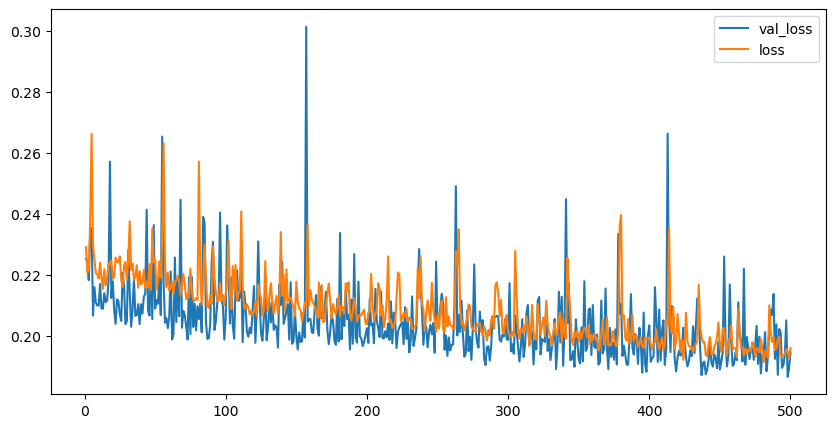

In [103]:
valLoss = history.history['val_loss']
loss = history.history['loss']
plt.figure(figsize=(10,5))
plt.plot([i for i in range(1,len(loss)+1)],valLoss,label='val_loss')
plt.plot([i for i in range(1,len(loss)+1)],loss,label='loss')
plt.legend()
plt.show()
